In [2]:
import torch
import os
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import time as time
import nibabel as nib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from statsmodels.graphics.agreement import mean_diff_plot

/home/jeremy/jeremy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeremy/jeremy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeremy/jeremy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeremy/jeremy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

# Test Dataset 1

### Brain Err w/6 classes

In [77]:
ds1_mwf_6_echo_6_classes_whole = np.load("dataset-1-mwf-pred-w-sr-6-echo-6-classes-whole-brain-bn.npy", 
                                         allow_pickle=True)
ds1_mwf_6_echo_6_classes_lesion = np.load("dataset-1-mwf-pred-w-sr-6-echo-6-classes-lesion-bn.npy", 
                                          allow_pickle=True)

In [78]:
wholeBrainErr6Classes = pd.DataFrame()

In [79]:
wholeBrainErr6Classes["id"] = [i[0] for i in ds1_mwf_6_echo_6_classes_whole[0][0]]

In [80]:
columns = ["myelin", "iewf", "csff", "myelinT2", "iewfT2", "csffT2"]
for i in range(len(columns)):
    wholeBrainErr6Classes[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_6_echo_6_classes_whole[0][i]]
    wholeBrainErr6Classes[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_6_echo_6_classes_whole[1][i]]

In [81]:
lesionErr6Classes = pd.DataFrame()

In [82]:
lesionErr6Classes["id"] = [i[0] for i in ds1_mwf_6_echo_6_classes_lesion[0][0]]

In [83]:
columns = ["myelin", "iewf", "csff", "myelinT2", "iewfT2", "csffT2"]
for i in range(len(columns)):
    lesionErr6Classes[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_6_echo_6_classes_lesion[0][i]]
    lesionErr6Classes[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_6_echo_6_classes_lesion[1][i]]

In [90]:
"{:.5f}±{:3f}".format(wholeBrainErr6Classes["unet_myelin"].mean(), wholeBrainErr6Classes["unet_myelin"].std())

'0.00501±0.000743'

In [94]:
"{:.4f}±{:.5f}".format(wholeBrainErr6Classes["mlp_myelin"].mean(), wholeBrainErr6Classes["mlp_myelin"].std())

'0.0119±0.00111'

In [322]:
for key in ["myelin", "iewf", "csff", "myelinT2", "iewfT2", "csffT2"]:
    if (key != 'id'):
        print(ranksums(wholeBrainErr6Classes['unet_'+key], wholeBrainErr6Classes['mlp_'+key]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)
RanksumsResult(statistic=-8.755716189368817, pvalue=2.028114762891134e-18)
RanksumsResult(statistic=9.565662629845399, pvalue=1.1148499862703548e-21)
RanksumsResult(statistic=-9.502233089326147, pvalue=2.0543672611285425e-21)
RanksumsResult(statistic=-2.3054198381035196, pvalue=0.021143071510364896)
RanksumsResult(statistic=4.0716885817934125, pvalue=4.667355302507867e-05)


In [327]:
def create6ClassGraph(graphType):
    columns_list = [["myelin", "iewf", "csff"], ["myelinT2", "iewfT2", "csffT2"]]
    labels_list = [["MWF", "IEWF", "CSFF"], ["Myelin T2", "IEWF T2", "CSFF T2"]]
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    err = wholeBrainErr6Classes if graphType == 'WHOLE' else lesionErr6Classes
    for idx in range(len(columns_list)):
        columns = columns_list[idx]
        X1 = [0+i*1.5 for i in range(len(columns))]
        axs[idx].bar(X1, 
                     [err['unet_'+key].mean() for key in columns], 
                     width = 0.5, 
                     yerr=[err['unet_'+key].std() for key in columns], 
                     label="UNET")

        X2 = [0.5+i*1.5 for i in range(len(columns))]
        axs[idx].bar(X2,
                     [err['mlp_'+key].mean() for key in columns], 
                     width = 0.5, 
                     yerr=[err['mlp_'+key].std() for key in columns], 
                     label="MLP")

        axs[idx].set_xticks([0.25 + i*1.5 for i in range(len(columns))])
        axs[idx].set_xticklabels(labels_list[idx])
        axs[idx].set_ylabel("MAE " + ("(%)" if idx < 1 else "(ms)"))
        axs[idx].legend()
    return fig, axs

(0.0, 0.02)

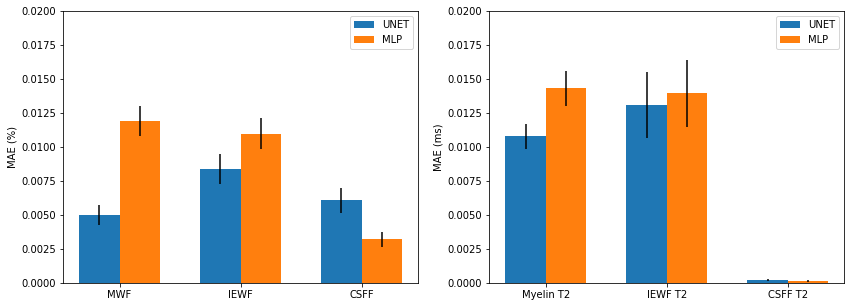

In [328]:
figWhole, axsWhole = create6ClassGraph('WHOLE')
axs = axsWhole 
arrowprops = {"arrowstyle": "-", "shrinkA": 5, "shrinkB": 5, "connectionstyle": "bar"}
axs[0].set_ylim(0, 0.02)
# axs[0].annotate("p < 0.001", xy=(-0.01,0.0145))
# axs[0].annotate("", xy=(0,0.0135),xytext=(0.005,0.0135), arrowprops=arrowprops)
# axs[0].annotate("p < 0.001", xy=(-0.014,0.0145))
# axs[0].annotate("", xy=(-0.015,0.0135),xytext=(2,1.35), arrowprops=arrowprops)
# axs[0].annotate("p < 0.001", xy=(2.9,1.1))
# axs[0].annotate("", xy=(3,1),xytext=(3.5,1), arrowprops=arrowprops)

axs[1].set_ylim(0, 0.02)
# axs[1].annotate("p < 0.001", xy=(-0.1,1.75))
# axs[1].annotate("", xy=(0.0,1.65),xytext=(0.5,1.65), arrowprops=arrowprops)
# axs[1].annotate("p < 0.05", xy=(1.4,1.75))
# axs[1].annotate("", xy=(1.5,1.65),xytext=(2,1.65), arrowprops=arrowprops)
# axs[1].annotate("p < 0.001", xy=(2.9,0.2))
# axs[1].annotate("", xy=(3,0.1),xytext=(3.5,0.1), arrowprops=arrowprops)
# figWhole.suptitle("Mean Absolute Error (MAE) for all 6 T2 Maps over Whole Brain")

In [329]:
for key in ["myelin", "iewf", "csff", "myelinT2", "iewfT2", "csffT2"]:
    if (key != 'id'):
        print(key, ranksums(lesionErr6Classes['unet_'+key], lesionErr6Classes['mlp_'+key]))

myelin RanksumsResult(statistic=-8.877634206043329, pvalue=6.82974096306591e-19)
iewf RanksumsResult(statistic=-6.293401076164134, pvalue=3.105844677142482e-10)
csff RanksumsResult(statistic=3.816844326696573, pvalue=0.00013516939355084253)
myelinT2 RanksumsResult(statistic=-7.443838193193688, pvalue=9.780128078831041e-14)
iewfT2 RanksumsResult(statistic=0.3485314418587071, pvalue=0.7274411050772472)
csffT2 RanksumsResult(statistic=6.775111199058283, pvalue=1.2431061023766396e-11)


(0.0, 0.04)

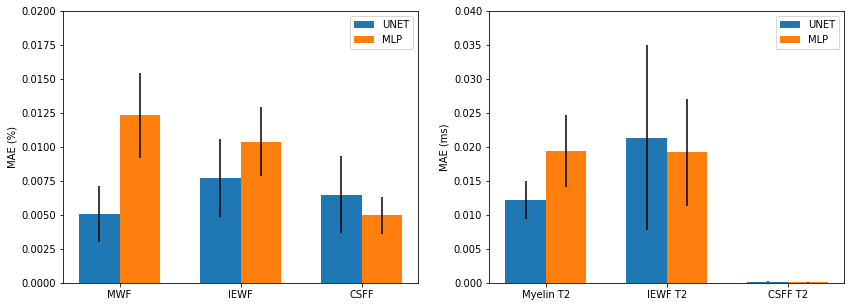

In [330]:
figLesion, axsLesion = create6ClassGraph('LESION')
axs = axsLesion
arrowprops = {"arrowstyle": "-", "shrinkA": 5, "shrinkB": 5, "connectionstyle": "bar"}
axs[0].set_ylim(0, 0.02)
# axs[0].annotate("p < 0.001", xy=(-0.1,1.7))
# axs[0].annotate("", xy=(0,1.6),xytext=(0.5,1.6), arrowprops=arrowprops)
# axs[0].annotate("p < 0.001", xy=(1.4,1.45))
# axs[0].annotate("", xy=(1.5,1.35),xytext=(2,1.35), arrowprops=arrowprops)
# axs[0].annotate("p < 0.001", xy=(2.9,1.1))
# axs[0].annotate("", xy=(3,1),xytext=(3.5,1), arrowprops=arrowprops)

axs[1].set_ylim(0, 0.04)
# axs[1].annotate("p < 0.001", xy=(-0.1,2.85))
# axs[1].annotate("", xy=(0.0,2.65),xytext=(0.5,2.65), arrowprops=arrowprops)
# axs[1].annotate("NS", xy=(1.65,3.8))
# axs[1].annotate("", xy=(1.5,3.6),xytext=(2,3.6), arrowprops=arrowprops)
# axs[1].annotate("p < 0.001", xy=(2.9,0.3))
# axs[1].annotate("", xy=(3,0.1),xytext=(3.5,0.1), arrowprops=arrowprops)
# figLesion.suptitle("Mean Absolute Error (MAE) for all 6 T2 Maps over Lesion Area")

In [331]:
wholeBrainErr6Classes.to_csv("results_v3/csv/wholeBrainErr6Classes.csv")
lesionErr6Classes.to_csv("results_v3/csv/lesionErr6Classes.csv")

### Brain Err w/32 echoes

In [58]:
ds1_mwf_32_echo_200_snr_whole = np.load("dataset-1-mwf-pred-w-sr-32-echo-200-snr-whole-brain-bn.npy", 
                                         allow_pickle=True)
ds1_mwf_32_echo_200_snr_lesion = np.load("dataset-1-mwf-pred-w-sr-32-echo-200-snr-lesion-bn.npy", 
                                         allow_pickle=True)

In [59]:
wholeBrainErr32EchoSim = pd.DataFrame()

In [60]:
print(len(ds1_mwf_32_echo_200_snr_whole))

2


In [61]:
wholeBrainErr32EchoSim["id"] = [i[0] for i in ds1_mwf_32_echo_200_snr_whole[0][0]]

In [62]:
columns = ["MWF"]
for i in range(len(columns)):
    wholeBrainErr32EchoSim[f"unet_{columns[i]}_snr200"] = \
        [subj[1]/100 for subj in ds1_mwf_32_echo_200_snr_whole[0][i]]
    wholeBrainErr32EchoSim[f"mlp_{columns[i]}_snr200"] = [subj[1]/100 for subj in ds1_mwf_32_echo_200_snr_whole[1][i]]

In [75]:
print(ranksums(wholeBrainErr32EchoSim["unet_MWF_snr200"], wholeBrainErr32EchoSim["mlp_MWF_snr200"]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)


In [71]:
lesionErr32EchoSim = pd.DataFrame()

In [72]:
lesionErr32EchoSim["id"] = [i[0] for i in ds1_mwf_32_echo_200_snr_lesion[0][0]]

In [73]:
columns = ["MWF"]
for i in range(len(columns)):
    lesionErr32EchoSim[f"unet_{columns[i]}_snr200"] = [subj[1]/100 for subj in ds1_mwf_32_echo_200_snr_lesion[0][i]]
    lesionErr32EchoSim[f"mlp_{columns[i]}_snr200"] = [subj[1]/100 for subj in ds1_mwf_32_echo_200_snr_lesion[1][i]]

In [74]:
"{:.4f}±{:.5f}".format(lesionErr32EchoSim["unet_MWF_snr200"].mean(),
                       lesionErr32EchoSim["unet_MWF_snr200"].std())

'0.0114±0.00216'

In [76]:
"{:.4f}±{:.5f}".format(lesionErr32EchoSim["mlp_MWF_snr200"].mean(),
                       lesionErr32EchoSim["mlp_MWF_snr200"].std())

'0.0194±0.00233'

In [11]:
print(ranksums(lesionErr32EchoSim["unet_MWF_snr200"], lesionErr32EchoSim["mlp_MWF_snr200"]))

RanksumsResult(statistic=-9.04764954353538, pvalue=1.4607874731309525e-19)


In [12]:
wholeBrainErr32EchoSim.to_csv("results_v3/csv/wholeBrainErr32EchoSim.csv")
lesionErr32EchoSim.to_csv("results_v3/csv/lesionErr32EchoSim.csv")

(0.0, 0.03)

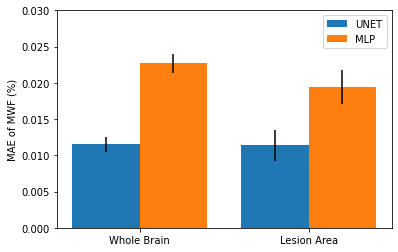

In [13]:
plt.bar([0, 0.5], 
        [wholeBrainErr32EchoSim['unet_MWF_snr200'].mean(), lesionErr32EchoSim['unet_MWF_snr200'].mean()], 
        yerr = [wholeBrainErr32EchoSim['unet_MWF_snr200'].std(), lesionErr32EchoSim['unet_MWF_snr200'].std()], 
        width=0.2, label="UNET")
plt.bar([0.2, 0.7], 
        [wholeBrainErr32EchoSim['mlp_MWF_snr200'].mean(), lesionErr32EchoSim['mlp_MWF_snr200'].mean()], 
        yerr = [wholeBrainErr32EchoSim['mlp_MWF_snr200'].std(), lesionErr32EchoSim['mlp_MWF_snr200'].std()], 
        width=0.2, label="MLP")
plt.legend()
plt.xticks(ticks=[0.1, 0.6], labels=["Whole Brain", "Lesion Area"])
plt.ylabel("MAE of MWF (%)")
# plt.title("MAE for MWF prediction on 32 Echo Simulations")

arrowprops = {"arrowstyle": "-", "shrinkA": 10, "shrinkB": 10, "connectionstyle": "bar"}
plt.ylim(0, 0.03)
# plt.xlim(-0.2, 1.1)
# plt.annotate("p < 0.001", xy=(0.01,2.8))
# plt.annotate("", xy=(0,2.5),xytext=(0.2,2.5), arrowprops=arrowprops)

# plt.annotate("p < 0.001", xy=(0.51,2.8))
# plt.annotate("", xy=(0.5,2.5),xytext=(0.7,2.5), arrowprops=arrowprops)

### Brain Err w/o SR

In [9]:
ds1_mwf_no_sr_6_echo_whole = np.load("dataset-1-mwf-pred-wo-sr-6-echo-whole-brain-bn.npy", 
                                     allow_pickle = True)
ds1_mwf_no_sr_6_echo_lesion = np.load("dataset-1-mwf-pred-wo-sr-6-echo-lesion-bn.npy", 
                                      allow_pickle = True)

In [10]:
wholeBrainErrNoSR = pd.DataFrame()

In [11]:
print(len(ds1_mwf_no_sr_6_echo_whole))

2


In [12]:
wholeBrainErrNoSR["id"] = [i[0] for i in ds1_mwf_no_sr_6_echo_whole[0][0]]

In [13]:
columns = ["MWF"]
for i in range(len(columns)):
    wholeBrainErrNoSR[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_no_sr_6_echo_whole[0][i]]
    wholeBrainErrNoSR[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_no_sr_6_echo_whole[1][i]]

In [14]:
lesionErrNoSR = pd.DataFrame()

In [15]:
lesionErrNoSR["id"] = [i[0] for i in ds1_mwf_no_sr_6_echo_lesion[0][0]]

In [16]:
columns = ["MWF"]
for i in range(len(columns)):
    lesionErrNoSR[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_no_sr_6_echo_lesion[0][i]]
    lesionErrNoSR[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_no_sr_6_echo_lesion[1][i]]

In [17]:
print(ranksums(wholeBrainErrNoSR["unet_MWF"], wholeBrainErrNoSR["mlp_MWF"]))
print(ranksums(lesionErrNoSR["unet_MWF"], lesionErrNoSR["mlp_MWF"]))

RanksumsResult(statistic=9.492474698477032, pvalue=2.2561338478986385e-21)
RanksumsResult(statistic=8.242910279406333, pvalue=1.680716054210941e-16)


In [23]:
wholeBrainErrNoSR.to_csv("results_v3/csv/wholeBrainErrNoSR.csv")
lesionErrNoSR.to_csv("results_v3/csv/lesionErrNoSR.csv")

(0.0, 0.015)

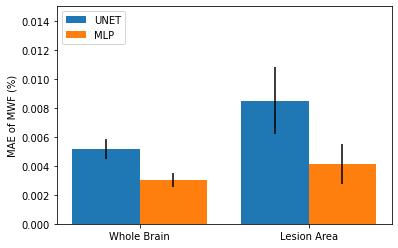

In [18]:
plt.bar([0, 0.5], 
        [wholeBrainErrNoSR['unet_MWF'].mean(), lesionErrNoSR['unet_MWF'].mean()], 
        yerr = [wholeBrainErrNoSR['unet_MWF'].std(), lesionErrNoSR['unet_MWF'].std()], 
        width=0.2, label="UNET")
plt.bar([0.2, 0.7], 
        [wholeBrainErrNoSR['mlp_MWF'].mean(), lesionErrNoSR['mlp_MWF'].mean()], 
        yerr = [wholeBrainErrNoSR['mlp_MWF'].std(), lesionErrNoSR['mlp_MWF'].std()], 
        width=0.2, label="MLP")
plt.legend(loc='upper left')
plt.xticks(ticks=[0.1, 0.6], labels=["Whole Brain", "Lesion Area"])
plt.ylabel("MAE of MWF (%)")
# plt.title("MAE for MWF prediction without Spatial Regularization")

# arrowprops = {"arrowstyle": "-", "shrinkA": 10, "shrinkB": 10, "connectionstyle": "bar"}
plt.ylim(0, 0.015)
# plt.annotate("p < 0.001", xy=(0.028,0.78))
# plt.annotate("", xy=(0,0.6),xytext=(0.2,0.6), arrowprops=arrowprops)

# plt.annotate("p < 0.001", xy=(0.528,1.38))
# plt.annotate("", xy=(0.5,1.2),xytext=(0.7,1.2), arrowprops=arrowprops)

### Brain Err w/SR (only MWF)

In [99]:
print(ranksums(lesionErr6Classes["unet_myelin"], lesionErrSROnlyMWF["unet_MWF"]))
print(ranksums(lesionErr6Classes["mlp_myelin"], lesionErrSROnlyMWF["mlp_MWF"]))

RanksumsResult(statistic=3.930187885024608, pvalue=8.487950950784582e-05)
RanksumsResult(statistic=0.24652223936347575, pvalue=0.8052779910303395)


In [53]:
"{:.5f}±{:.6f}".format(wholeBrainErrSROnlyMWF["unet_MWF"].mean(), wholeBrainErrSROnlyMWF["unet_MWF"].std())

'0.00440±0.000718'

In [54]:
"{:.5f}±{:.6f}".format(wholeBrainErrNoSR["unet_MWF"].mean(), wholeBrainErrNoSR["unet_MWF"].std())

'0.00515±0.000705'

In [51]:
"{:.4f}±{:.5f}".format(wholeBrainErrSROnlyMWF["mlp_MWF"].mean(), wholeBrainErrSROnlyMWF["mlp_MWF"].std())

'0.0115±0.00122'

In [56]:
"{:.5f}±{:.6f}".format(wholeBrainErrNoSR["mlp_MWF"].mean(), wholeBrainErrNoSR["mlp_MWF"].std())

'0.00303±0.000503'

In [19]:
ds1_mwf_sr_6_echo_whole = np.load("dataset-1-mwf-pred-w-sr-6-echo-whole-brain-bn.npy", 
                                  allow_pickle = True)
ds1_mwf_sr_6_echo_lesion = np.load("dataset-1-mwf-pred-w-sr-6-echo-lesion-bn.npy", 
                                   allow_pickle = True)

In [20]:
wholeBrainErrSROnlyMWF = pd.DataFrame()

In [21]:
print(len(ds1_mwf_sr_6_echo_whole))

2


In [22]:
wholeBrainErrSROnlyMWF["id"] = [i[0] for i in ds1_mwf_sr_6_echo_whole[0][0]]

In [23]:
columns = ["MWF"]
for i in range(len(columns)):
    wholeBrainErrSROnlyMWF[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_sr_6_echo_whole[0][i]]
    wholeBrainErrSROnlyMWF[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_sr_6_echo_whole[1][i]]

In [24]:
lesionErrSROnlyMWF = pd.DataFrame()

In [25]:
lesionErrSROnlyMWF["id"] = [i[0] for i in ds1_mwf_sr_6_echo_lesion[0][0]]

In [26]:
columns = ["MWF"]
for i in range(len(columns)):
    lesionErrSROnlyMWF[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_sr_6_echo_lesion[0][i]]
    lesionErrSROnlyMWF[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds1_mwf_sr_6_echo_lesion[1][i]]

In [27]:
print(ranksums(wholeBrainErrSROnlyMWF["unet_MWF"], wholeBrainErrSROnlyMWF["mlp_MWF"]))
print(ranksums(lesionErrSROnlyMWF["unet_MWF"], lesionErrSROnlyMWF["mlp_MWF"]))

RanksumsResult(statistic=-9.682763320034782, pvalue=3.569355687242394e-22)
RanksumsResult(statistic=-9.14399156811421, pvalue=6.018877684928938e-20)


In [34]:
wholeBrainErrSROnlyMWF.to_csv("results_v3/csv/wholeBrainErrSROnlyMWF.csv")
lesionErrSROnlyMWF.to_csv("results_v3/csv/lesionErrSROnlyMWF.csv")

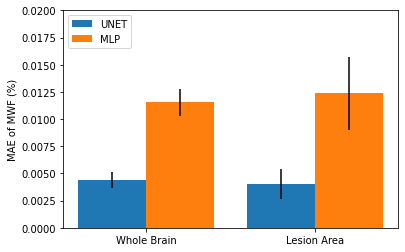

In [28]:
plt.bar([0, 0.5], 
        [wholeBrainErrSROnlyMWF['unet_MWF'].mean(), lesionErrSROnlyMWF['unet_MWF'].mean()], 
        yerr = [wholeBrainErrSROnlyMWF['unet_MWF'].std(), lesionErrSROnlyMWF['unet_MWF'].std()], 
        width=0.2, label="UNET")
plt.bar([0.2, 0.7], 
        [wholeBrainErrSROnlyMWF['mlp_MWF'].mean(), lesionErrSROnlyMWF['mlp_MWF'].mean()], 
        yerr = [wholeBrainErrSROnlyMWF['mlp_MWF'].std(), lesionErrSROnlyMWF['mlp_MWF'].std()], 
        width=0.2, label="MLP")
plt.legend(loc='upper left')
plt.xticks(ticks=[0.1, 0.6], labels=["Whole Brain", "Lesion Area"])
plt.ylabel("MAE of MWF (%)")
# plt.title("MAE for MWF prediction with Spatial Regularization")

# arrowprops = {"arrowstyle": "-", "shrinkA": 15, "shrinkB": 15, "connectionstyle": "bar"}
plt.ylim(0, 0.02)
plt.rcParams["figure.figsize"] = (5,3)
# plt.annotate("p < 0.001", xy=(0.028,1.45))
# plt.annotate("", xy=(0,1.2),xytext=(0.2,1.2), arrowprops=arrowprops)

# plt.annotate("p < 0.001", xy=(0.528,1.75))
# plt.annotate("", xy=(0.5,1.5),xytext=(0.7,1.5), arrowprops=arrowprops)

### 2245 Sim on 6 Params

In [36]:
ds1_sim_full = np.load("dataset-1-sim-6-classes-FULL-results-bn.npy", 
                       allow_pickle = True)
ds1_sim_avg = np.load("dataset-1-sim-6-classes-avg-results-bn.npy", 
                      allow_pickle = True)

In [309]:
wholeBrainErr2245Sim = pd.DataFrame()

wholeBrainErr2245Sim["simulationRound"] = range(len(ds1_sim_full[0]["res256snr200"]))

features = ['MWF', 'IEWF', 'CSFF', 'MWF_T2', 'IEWF_T2', 'CSFF_T2']
columns = ["snr200", "snr100", "snr50"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full[1][f"res256{column}"]]
        wholeBrainErr2245Sim[f"unet_{feature}_{column}"] = unetData
        wholeBrainErr2245Sim[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(wholeBrainErr2245Sim[f"unet_{feature}_snr200"], 
                   wholeBrainErr2245Sim[f"mlp_{feature}_snr200"]))
    print(ranksums(wholeBrainErr2245Sim[f"unet_{feature}_snr100"], 
                   wholeBrainErr2245Sim[f"mlp_{feature}_snr100"]))
    print(ranksums(wholeBrainErr2245Sim[f"unet_{feature}_snr50"], 
                   wholeBrainErr2245Sim[f"mlp_{feature}_snr50"]))

lesionErr2245Sim = pd.DataFrame()

lesionErr2245Sim["simulationRound"] = range(len(ds1_sim_full[0]["res256snr200Lesion"]))

features = ['MWF', 'IEWF', 'CSFF', 'MWF_T2', 'IEWF_T2', 'CSFF_T2']
columns = ["snr200Lesion", "snr100Lesion", "snr50Lesion"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full[1][f"res256{column}"]]
        lesionErr2245Sim[f"unet_{feature}_{column}"] = unetData
        lesionErr2245Sim[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(lesionErr2245Sim[f"unet_{feature}_snr200Lesion"], 
                   lesionErr2245Sim[f"mlp_{feature}_snr200Lesion"]))
    print(ranksums(lesionErr2245Sim[f"unet_{feature}_snr100Lesion"], 
                   lesionErr2245Sim[f"mlp_{feature}_snr100Lesion"]))
    print(ranksums(lesionErr2245Sim[f"unet_{feature}_snr50Lesion"], 
                   lesionErr2245Sim[f"mlp_{feature}_snr50Lesion"]))

=============MWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
=============IEWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
=============CSFF=============
RanksumsResult(statistic=27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
=============MWF_T2=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.

In [310]:
wholeBrainErr2245Sim.to_csv("results_v3/csv/wholeBrainErr2245Sim6Classes.csv")
lesionErr2245Sim.to_csv("results_v3/csv/lesionErr2245Sim6Classes.csv")

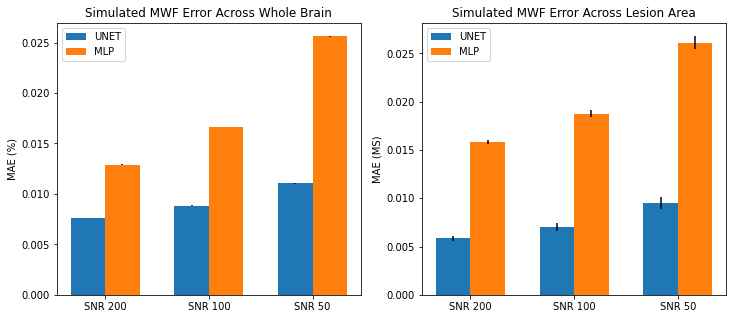

In [311]:
WHOLE_BRAIN_UNET200 = 0
WHOLE_BRAIN_UNET100 = 0.15
WHOLE_BRAIN_UNET50 = 0.3
# WHOLE_BRAIN_UNET25 = 0.45

WHOLE_BRAIN_MLP200 = 0.05
WHOLE_BRAIN_MLP100 = 0.2
WHOLE_BRAIN_MLP50 = 0.35
# WHOLE_BRAIN_MLP25 = 0.5

fig, axs = plt.subplots(1,2, figsize=(12,5))
# fig.subplots_adjust(right=1.5)
# fig.suptitle("MWF MAE when trained to predict 6 T2 Maps")

axs[0].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [wholeBrainErr2245Sim["unet_MWF_snr200"].mean(),wholeBrainErr2245Sim["unet_MWF_snr100"].mean(),
            wholeBrainErr2245Sim["unet_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245Sim["unet_MWF_snr200"].std(),wholeBrainErr2245Sim["unet_MWF_snr100"].std(),
                 wholeBrainErr2245Sim["unet_MWF_snr50"].std()],
           width=0.05, label = "UNET")

axs[0].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [wholeBrainErr2245Sim["mlp_MWF_snr200"].mean(), wholeBrainErr2245Sim["mlp_MWF_snr100"].mean(),
            wholeBrainErr2245Sim["mlp_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245Sim["mlp_MWF_snr200"].std(), wholeBrainErr2245Sim["mlp_MWF_snr100"].std(),
                 wholeBrainErr2245Sim["mlp_MWF_snr50"].std()], 
           width=0.05, label = "MLP")

axs[0].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[0].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[0].set_ylabel("MAE (%)")
axs[0].set_title("Simulated MWF Error Across Whole Brain")
axs[0].legend(loc = "upper left")

axs[1].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [lesionErr2245Sim["unet_MWF_snr200Lesion"].mean(), 
            lesionErr2245Sim["unet_MWF_snr100Lesion"].mean(),
            lesionErr2245Sim["unet_MWF_snr50Lesion"].mean()], 
           yerr=[lesionErr2245Sim["unet_MWF_snr200Lesion"].std(), 
                 lesionErr2245Sim["unet_MWF_snr100Lesion"].std(),
                 lesionErr2245Sim["unet_MWF_snr50Lesion"].std()],
           width=0.05, label = "UNET")

axs[1].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [lesionErr2245Sim["mlp_MWF_snr200Lesion"].mean(), 
            lesionErr2245Sim["mlp_MWF_snr100Lesion"].mean(),
            lesionErr2245Sim["mlp_MWF_snr50Lesion"].mean()],
           yerr=[lesionErr2245Sim["mlp_MWF_snr200Lesion"].std(),
                 lesionErr2245Sim["mlp_MWF_snr100Lesion"].std(),
                 lesionErr2245Sim["mlp_MWF_snr50Lesion"].std()],
           width=0.05, label = "MLP")

axs[1].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[1].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[1].set_ylabel("MAE (MS)")
axs[1].set_title("Simulated MWF Error Across Lesion Area")
axs[1].legend(loc = "upper left")

plt.show()

### 2245 Sim on No SR

In [37]:
ds1_sim_full_no_sr = np.load("dataset-1-sim-6-classes-no-sr-FULL-results-bn.npy", 
                       allow_pickle = True)
ds1_sim_avg_no_sr = np.load("dataset-1-sim-6-classes-no-sr-avg-results-bn.npy", 
                      allow_pickle = True)

In [41]:
wholeBrainErr2245SimNoSr = pd.DataFrame()

wholeBrainErr2245SimNoSr["simulationRound"] = range(len(ds1_sim_full_no_sr[0]["res256snr200"]))

features = ['MWF']
columns = ["snr200", "snr100", "snr50"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_no_sr[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_no_sr[1][f"res256{column}"]]
        wholeBrainErr2245SimNoSr[f"unet_{feature}_{column}"] = unetData
        wholeBrainErr2245SimNoSr[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(wholeBrainErr2245SimNoSr[f"unet_{feature}_snr200"], 
                   wholeBrainErr2245SimNoSr[f"mlp_{feature}_snr200"]))
    print(ranksums(wholeBrainErr2245SimNoSr[f"unet_{feature}_snr100"], 
                   wholeBrainErr2245SimNoSr[f"mlp_{feature}_snr100"]))
    print(ranksums(wholeBrainErr2245SimNoSr[f"unet_{feature}_snr50"], 
                   wholeBrainErr2245SimNoSr[f"mlp_{feature}_snr50"]))

lesionErr2245SimNoSr = pd.DataFrame()

lesionErr2245SimNoSr["simulationRound"] = range(len(ds1_sim_full_no_sr[0]["res256snr200Lesion"]))

features = ['MWF']
columns = ["snr200Lesion", "snr100Lesion", "snr50Lesion"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_no_sr[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_no_sr[1][f"res256{column}"]]
        lesionErr2245SimNoSr[f"unet_{feature}_{column}"] = unetData
        lesionErr2245SimNoSr[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(lesionErr2245SimNoSr[f"unet_{feature}_snr200Lesion"], 
                   lesionErr2245SimNoSr[f"mlp_{feature}_snr200Lesion"]))
    print(ranksums(lesionErr2245SimNoSr[f"unet_{feature}_snr100Lesion"], 
                   lesionErr2245SimNoSr[f"mlp_{feature}_snr100Lesion"]))
    print(ranksums(lesionErr2245SimNoSr[f"unet_{feature}_snr50Lesion"], 
                   lesionErr2245SimNoSr[f"mlp_{feature}_snr50Lesion"]))

=============MWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
=============MWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.37025527696214, pvalue=6.1998476793461e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)


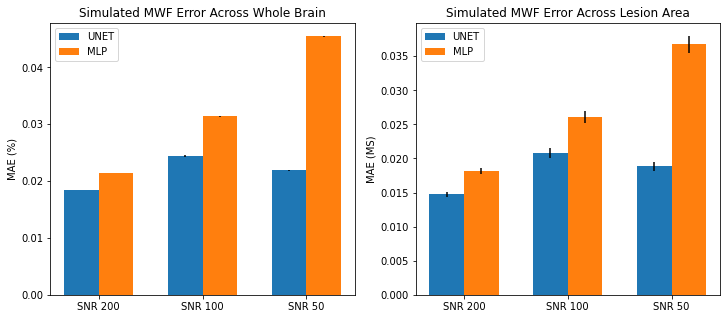

In [42]:
WHOLE_BRAIN_UNET200 = 0
WHOLE_BRAIN_UNET100 = 0.15
WHOLE_BRAIN_UNET50 = 0.3
# WHOLE_BRAIN_UNET25 = 0.45

WHOLE_BRAIN_MLP200 = 0.05
WHOLE_BRAIN_MLP100 = 0.2
WHOLE_BRAIN_MLP50 = 0.35
# WHOLE_BRAIN_MLP25 = 0.5

fig, axs = plt.subplots(1,2, figsize=(12,5))
# fig.subplots_adjust(right=1.5)
# fig.suptitle("MWF MAE when trained to predict 6 T2 Maps")

axs[0].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [wholeBrainErr2245SimNoSr["unet_MWF_snr200"].mean(),wholeBrainErr2245SimNoSr["unet_MWF_snr100"].mean(),
            wholeBrainErr2245SimNoSr["unet_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245SimNoSr["unet_MWF_snr200"].std(),wholeBrainErr2245SimNoSr["unet_MWF_snr100"].std(),
                 wholeBrainErr2245SimNoSr["unet_MWF_snr50"].std()],
           width=0.05, label = "UNET")

axs[0].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [wholeBrainErr2245SimNoSr["mlp_MWF_snr200"].mean(), wholeBrainErr2245SimNoSr["mlp_MWF_snr100"].mean(),
            wholeBrainErr2245SimNoSr["mlp_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245SimNoSr["mlp_MWF_snr200"].std(), wholeBrainErr2245SimNoSr["mlp_MWF_snr100"].std(),
                 wholeBrainErr2245SimNoSr["mlp_MWF_snr50"].std()], 
           width=0.05, label = "MLP")

axs[0].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[0].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[0].set_ylabel("MAE (%)")
axs[0].set_title("Simulated MWF Error Across Whole Brain")
axs[0].legend(loc = "upper left")

axs[1].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [lesionErr2245SimNoSr["unet_MWF_snr200Lesion"].mean(), 
            lesionErr2245SimNoSr["unet_MWF_snr100Lesion"].mean(),
            lesionErr2245SimNoSr["unet_MWF_snr50Lesion"].mean()], 
           yerr=[lesionErr2245SimNoSr["unet_MWF_snr200Lesion"].std(), 
                 lesionErr2245SimNoSr["unet_MWF_snr100Lesion"].std(),
                 lesionErr2245SimNoSr["unet_MWF_snr50Lesion"].std()],
           width=0.05, label = "UNET")

axs[1].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [lesionErr2245SimNoSr["mlp_MWF_snr200Lesion"].mean(), 
            lesionErr2245SimNoSr["mlp_MWF_snr100Lesion"].mean(),
            lesionErr2245SimNoSr["mlp_MWF_snr50Lesion"].mean()],
           yerr=[lesionErr2245SimNoSr["mlp_MWF_snr200Lesion"].std(),
                 lesionErr2245SimNoSr["mlp_MWF_snr100Lesion"].std(),
                 lesionErr2245SimNoSr["mlp_MWF_snr50Lesion"].std()],
           width=0.05, label = "MLP")

axs[1].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[1].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[1].set_ylabel("MAE (MS)")
axs[1].set_title("Simulated MWF Error Across Lesion Area")
axs[1].legend(loc = "upper left")

plt.show()

In [44]:
wholeBrainErr2245SimNoSr.to_csv("results_v3/csv/wholeBrainErr2245SimNoSr.csv")
lesionErr2245SimNoSr.to_csv("results_v3/csv/lesionErr2245SimNoSr.csv")

### 2245 Sim only MWF

=============MWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
=============MWF=============
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)


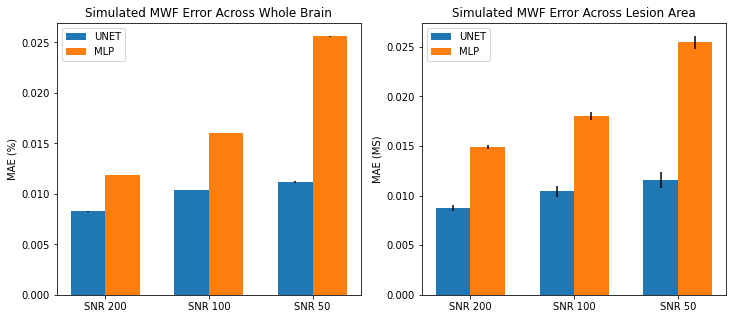

In [3]:
ds1_sim_full_mwf_only = np.load("dataset-1-sim-FULL-results-bn.npy", 
                       allow_pickle = True)
ds1_sim_avg_mwf_only = np.load("dataset-1-sim-avg-results-bn.npy", 
                      allow_pickle = True)

wholeBrainErr2245SimMWFOnly = pd.DataFrame()

wholeBrainErr2245SimMWFOnly["simulationRound"] = range(len(ds1_sim_full_mwf_only[0]["res256snr200"]))

features = ['MWF']
columns = ["snr200", "snr100", "snr50"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_mwf_only[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_mwf_only[1][f"res256{column}"]]
        wholeBrainErr2245SimMWFOnly[f"unet_{feature}_{column}"] = unetData
        wholeBrainErr2245SimMWFOnly[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(wholeBrainErr2245SimMWFOnly[f"unet_{feature}_snr200"], 
                   wholeBrainErr2245SimMWFOnly[f"mlp_{feature}_snr200"]))
    print(ranksums(wholeBrainErr2245SimMWFOnly[f"unet_{feature}_snr100"], 
                   wholeBrainErr2245SimMWFOnly[f"mlp_{feature}_snr100"]))
    print(ranksums(wholeBrainErr2245SimMWFOnly[f"unet_{feature}_snr50"], 
                   wholeBrainErr2245SimMWFOnly[f"mlp_{feature}_snr50"]))

lesionErr2245SimMWFOnly = pd.DataFrame()

lesionErr2245SimMWFOnly["simulationRound"] = range(len(ds1_sim_full_mwf_only[0]["res256snr200Lesion"]))

features = ['MWF']
columns = ["snr200Lesion", "snr100Lesion", "snr50Lesion"]
for feature_idx in range(len(features)):
    feature = features[feature_idx]
    for column in columns:
        unetData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_mwf_only[0][f"res256{column}"]]
        mlpData = [i[feature_idx][0][1]/100 for i in ds1_sim_full_mwf_only[1][f"res256{column}"]]
        lesionErr2245SimMWFOnly[f"unet_{feature}_{column}"] = unetData
        lesionErr2245SimMWFOnly[f"mlp_{feature}_{column}"] = mlpData

for feature in features:
    print(f'============={feature}=============')
    print(ranksums(lesionErr2245SimMWFOnly[f"unet_{feature}_snr200Lesion"], 
                   lesionErr2245SimMWFOnly[f"mlp_{feature}_snr200Lesion"]))
    print(ranksums(lesionErr2245SimMWFOnly[f"unet_{feature}_snr100Lesion"], 
                   lesionErr2245SimMWFOnly[f"mlp_{feature}_snr100Lesion"]))
    print(ranksums(lesionErr2245SimMWFOnly[f"unet_{feature}_snr50Lesion"], 
                   lesionErr2245SimMWFOnly[f"mlp_{feature}_snr50Lesion"]))

WHOLE_BRAIN_UNET200 = 0
WHOLE_BRAIN_UNET100 = 0.15
WHOLE_BRAIN_UNET50 = 0.3
# WHOLE_BRAIN_UNET25 = 0.45

WHOLE_BRAIN_MLP200 = 0.05
WHOLE_BRAIN_MLP100 = 0.2
WHOLE_BRAIN_MLP50 = 0.35
# WHOLE_BRAIN_MLP25 = 0.5

fig, axs = plt.subplots(1,2, figsize=(12,5))
# fig.subplots_adjust(right=1.5)
# fig.suptitle("MWF MAE when trained to predict 6 T2 Maps")

axs[0].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [wholeBrainErr2245SimMWFOnly["unet_MWF_snr200"].mean(),
            wholeBrainErr2245SimMWFOnly["unet_MWF_snr100"].mean(),
            wholeBrainErr2245SimMWFOnly["unet_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245SimMWFOnly["unet_MWF_snr200"].std(),
                 wholeBrainErr2245SimMWFOnly["unet_MWF_snr100"].std(),
                 wholeBrainErr2245SimMWFOnly["unet_MWF_snr50"].std()],
           width=0.05, label = "UNET")

axs[0].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [wholeBrainErr2245SimMWFOnly["mlp_MWF_snr200"].mean(), 
            wholeBrainErr2245SimMWFOnly["mlp_MWF_snr100"].mean(),
            wholeBrainErr2245SimMWFOnly["mlp_MWF_snr50"].mean()], 
           yerr=[wholeBrainErr2245SimMWFOnly["mlp_MWF_snr200"].std(), 
                 wholeBrainErr2245SimMWFOnly["mlp_MWF_snr100"].std(),
                 wholeBrainErr2245SimMWFOnly["mlp_MWF_snr50"].std()], 
           width=0.05, label = "MLP")

axs[0].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[0].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[0].set_ylabel("MAE (%)")
axs[0].set_title("Simulated MWF Error Across Whole Brain")
axs[0].legend(loc = "upper left")

axs[1].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50], 
           [lesionErr2245SimMWFOnly["unet_MWF_snr200Lesion"].mean(), 
            lesionErr2245SimMWFOnly["unet_MWF_snr100Lesion"].mean(),
            lesionErr2245SimMWFOnly["unet_MWF_snr50Lesion"].mean()], 
           yerr=[lesionErr2245SimMWFOnly["unet_MWF_snr200Lesion"].std(), 
                 lesionErr2245SimMWFOnly["unet_MWF_snr100Lesion"].std(),
                 lesionErr2245SimMWFOnly["unet_MWF_snr50Lesion"].std()],
           width=0.05, label = "UNET")

axs[1].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50], 
           [lesionErr2245SimMWFOnly["mlp_MWF_snr200Lesion"].mean(), 
            lesionErr2245SimMWFOnly["mlp_MWF_snr100Lesion"].mean(),
            lesionErr2245SimMWFOnly["mlp_MWF_snr50Lesion"].mean()],
           yerr=[lesionErr2245SimMWFOnly["mlp_MWF_snr200Lesion"].std(),
                 lesionErr2245SimMWFOnly["mlp_MWF_snr100Lesion"].std(),
                 lesionErr2245SimMWFOnly["mlp_MWF_snr50Lesion"].std()],
           width=0.05, label = "MLP")

axs[1].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2])
axs[1].set_xticklabels(["SNR 200", "SNR 100", "SNR 50"])
axs[1].set_ylabel("MAE (MS)")
axs[1].set_title("Simulated MWF Error Across Lesion Area")
axs[1].legend(loc = "upper left")

plt.show()

wholeBrainErr2245SimMWFOnly.to_csv("results_v3/csv/wholeBrainErr2245Sim.csv")
lesionErr2245SimMWFOnly.to_csv("results_v3/csv/lesionErr2245Sim.csv")

# Test Dataset 2

### Healthy Cases

RanksumsResult(statistic=-5.410017808004594, pvalue=6.301848221392269e-08)


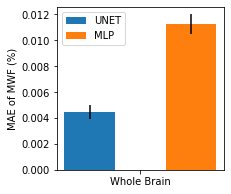

In [348]:
ds2_healthy = np.load("dataset-2-mwf-healthy-6-classes-bn.npy", allow_pickle = True)

wholeBrainErrHealthyCases = pd.DataFrame()

wholeBrainErrHealthyCases["id"] = [i[0] for i in ds2_healthy[0][0]]

columns = ["MWF"]
for i in range(len(columns)):
    wholeBrainErrHealthyCases[f"unet_{columns[i]}"] = [subj[1]/100 for subj in ds2_healthy[0][i]]
    wholeBrainErrHealthyCases[f"mlp_{columns[i]}"] = [subj[1]/100 for subj in ds2_healthy[1][i]]

print(ranksums(wholeBrainErrHealthyCases["unet_MWF"], wholeBrainErrHealthyCases["mlp_MWF"]))

wholeBrainErrHealthyCases.to_csv("results_v3/csv/wholeBrainErrHealthyCases6Classes.csv")

plt.bar([0], 
        [wholeBrainErrHealthyCases['unet_MWF'].mean()], 
        yerr = [wholeBrainErrHealthyCases['unet_MWF'].std()], 
        width=0.1, label="UNET")
plt.bar([0.2], 
        [wholeBrainErrHealthyCases['mlp_MWF'].mean()], 
        yerr = [wholeBrainErrHealthyCases['mlp_MWF'].std()], 
        width=0.1, label="MLP")
plt.legend(loc='upper left')
plt.xticks(ticks=[0.1], labels=["Whole Brain"])
plt.ylabel("MAE of MWF (%)")
plt.rcParams["figure.figsize"] = (2,3)
# plt.title("MAE for MWF prediction on Healthy Cases when Predicting all T2 Maps")

# Visualizations

### Real Brain MS Case

### Motion

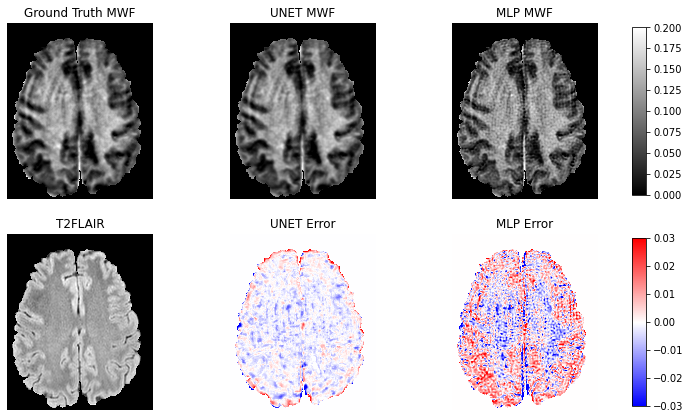

In [126]:
case = '1876'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1876": "1876_20190606_083112_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()/100
err_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

fig, axs = plt.subplots(2,3, figsize=(10,5))
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

### No Motion

In [265]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1898": "1898_20181215_155013_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()/100
err_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

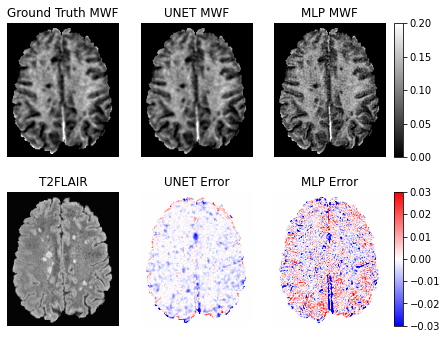

In [266]:
fig, axs = plt.subplots(2,3)
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

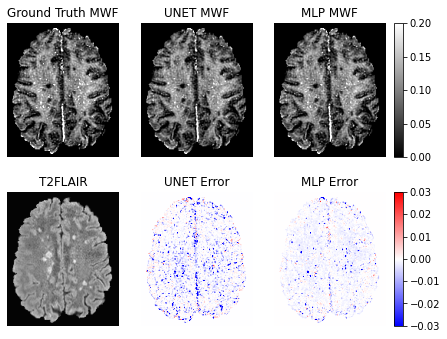

In [267]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1898": "1898_20181215_155013_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-no-sr-mwf-6-echo/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()/100
err_u = nib.load(f'results_v3/unet-no-sr-mwf-6-echo/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-no-sr-mwf-6-echo/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-no-sr-mwf-6-echo/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-no-sr-mwf-6-echo/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

fig, axs = plt.subplots(2,3)
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

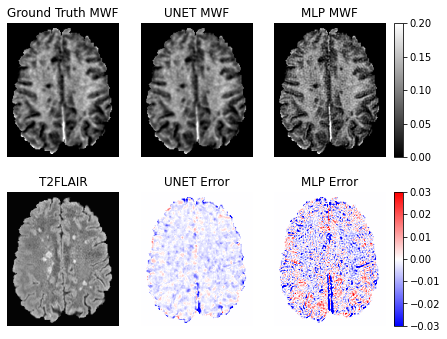

In [268]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1898": "1898_20181215_155013_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-6-echo/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()/100
err_u = nib.load(f'results_v3/unet-sr-mwf-6-echo/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-sr-mwf-6-echo/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

fig, axs = plt.subplots(2,3)
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

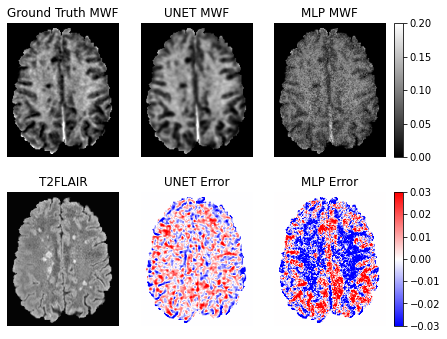

In [269]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1898": "1898_20181215_155013_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-32-echo-200-snr/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()/100
err_u = nib.load(f'results_v3/unet-sr-mwf-32-echo-200-snr/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-sr-mwf-32-echo-200-snr/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-sr-mwf-32-echo-200-snr/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-sr-mwf-32-echo-200-snr/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

fig, axs = plt.subplots(2,3)
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

### Real Brain Errors

### Bland Altman

In [404]:
rois = {
    "wm_frontal_lobe": [3201, 4201],
    "wm_parietal_lobe" : [3206, 4206],
    "wm_temporal_lobe" : [3205, 4205],
    "wm_occipital_lobe" : [3204, 4204],
    "thalamus" : [10, 49],
    "caudate" : [11, 50],
    "putamen" : [12, 51],
    "pallidum" : [13, 52]
}

keys = rois.keys()

In [405]:
def getROIMeans(method):
    numbers = [['184051','184052'],['111720','111721'],['151025','151026'],['113307','113308'],['171732','154655'],
               ['163834','163835'],['125545','125546'],['175630','175631'],['101850','101851'],['093923','093924']]
    values = []
    for number_pair in numbers:
        CASE_A = number_pair[0]
        CASE_B = number_pair[1]
        A_PATH = f"../{CASE_A}"
        B_PATH = f"../{CASE_B}"
        image_a = None
        image_b = None
        if (method == "UNET"):
            image_a = nib.load(f"results_v3/unet-healthy-6-classes/MWF/{CASE_A}_pred_UNET_MWF_repro.nii.gz").get_fdata()
            image_b = nib.load(f"results_v3/unet-healthy-6-classes/MWF/{CASE_B}_pred_UNET_MWF_repro.nii.gz").get_fdata()
        elif (method == "NLLS"):
            image_a = nib.load(f"{A_PATH}/MWF.nii.gz").get_fdata()
            image_b = nib.load(f"{B_PATH}/MWF.nii.gz").get_fdata()
        elif (method == "MLP"):
            image_a = nib.load(f"results_v3/mlp-healthy-6-classes/MWF/{CASE_A}_pred_MLP_repro.nii.gz").get_fdata()
            image_b = nib.load(f"results_v3/mlp-healthy-6-classes/MWF/{CASE_B}_pred_MLP_repro.nii.gz").get_fdata()
        seg_a = nib.load(f"{A_PATH}/segmentation.nii.gz").get_fdata()
        seg_b = nib.load(f"{B_PATH}/segmentation.nii.gz").get_fdata()
        means = {}
        for key in keys:
            mwfs_a = []
            mwfs_b = []
            means[key] = {}
            for seg in rois[key]:
                mwfs_a += image_a[seg_a == seg].reshape(-1).tolist()
                mwfs_b += image_b[seg_b == seg].reshape(-1).tolist()
            mwfs_a = np.array(mwfs_a)
            mwfs_b = np.array(mwfs_b)
            means[key]["A"] = mwfs_a.mean()/100
            means[key]["B"] = mwfs_b.mean()/100
            means[key]["id"] = CASE_A + "-" + str(rois[key][0]) + "," + str(rois[key][1]) + "-" + key
        values.append(means)
    return values

In [406]:
values_u = getROIMeans("UNET")
values_m = getROIMeans("MLP")
values_n = getROIMeans("NLLS")

In [407]:
reproDataNLLS = pd.DataFrame()
reproDataUNET = pd.DataFrame()
reproDataMLP = pd.DataFrame()

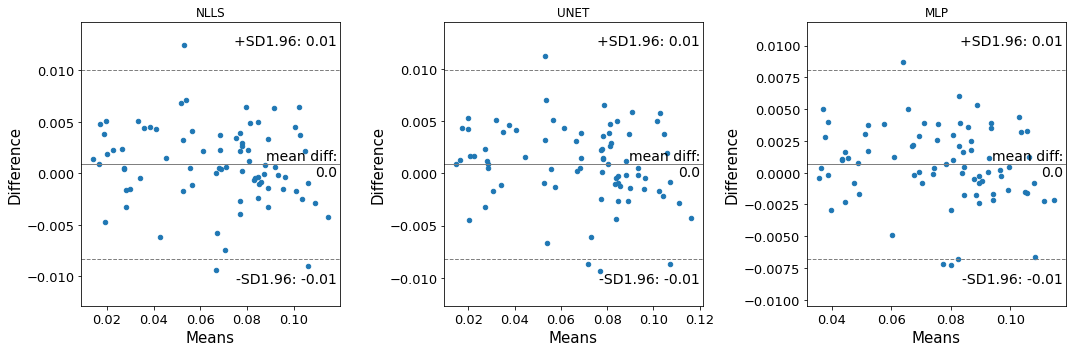

In [408]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
value_list = [values_n, values_u, values_m]
titles = ["NLLS", "UNET", "MLP"]
dfs = [reproDataNLLS, reproDataUNET, reproDataMLP]
for idx in range(len(axs)):
    ax = axs[idx]
    ax.set_title(titles[idx])
    values = value_list[idx]
    dataID = []
    data1 = []
    data2 = []
    for ROI in values:
        for key in keys:
            dataID.append(ROI[key]["id"])
            data1.append(ROI[key]["A"])
            data2.append(ROI[key]["B"])
    data1 = np.array(data1)
    data2 = np.array(data2)
    dfs[idx]["id"] = dataID
    dfs[idx]["scanv1"] = data1
    dfs[idx]["scanv2"] = data2
    mean_diff_plot(data1, data2, ax = ax, sd_limit=1.96,)
fig.show()
# fig.suptitle("Bland Altman Plot for MWF when Predicting all 6 T2 Maps")

In [412]:
reproDataNLLS.to_csv("results_v3/csv/reproDataNLLS6Classes.csv")
reproDataUNET.to_csv("results_v3/csv/reproDataUNET6Classes.csv")
reproDataMLP.to_csv("results_v3/csv/reproDataMLP6Classes.csv")

### Simulations Visualization

In [253]:
case = '2245'
FLAIR_PATH = {"2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u_50 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_pred_UNET_MWF_256sim_snr50.nii.gz')\
            .get_fdata()/100
image_u_100 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_pred_UNET_MWF_256sim_snr100.nii.gz')\
            .get_fdata()/100
image_u_200 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_pred_UNET_MWF_256sim_snr200.nii.gz')\
            .get_fdata()/100
err_u_50 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_err_UNET_MWF_256sim_snr50.nii.gz')\
            .get_fdata()/100
err_u_100 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_err_UNET_MWF_256sim_snr100.nii.gz')\
            .get_fdata()/100
err_u_200 = nib.load(f'results_v3/unet-2245-simulations-6-classes/MWF/{case}_err_UNET_MWF_256sim_snr200.nii.gz')\
            .get_fdata()/100

image_a_50 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_pred_MLP_256sim_snr50.nii.gz')\
            .get_fdata()/100
image_a_100 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_pred_MLP_256sim_snr100.nii.gz')\
            .get_fdata()/100
image_a_200 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_pred_MLP_256sim_snr200.nii.gz')\
            .get_fdata()/100
err_a_50 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_err_MLP_256sim_snr50.nii.gz')\
            .get_fdata()/100
err_a_100 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_err_MLP_256sim_snr100.nii.gz')\
            .get_fdata()/100
err_a_200 = nib.load(f'results_v3/mlp-2245-simulations-6-classes/MWF/{case}_err_MLP_256sim_snr200.nii.gz')\
            .get_fdata()/100

label = nib.load(f"results_v3/mlp-2245-simulations-6-classes/MWF/2245_label_MLP_256sim_snr100.nii.gz")\
            .get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/cropped_mask.nii.gz").get_fdata()
crop = nib.load("2245_crop.nii.gz").get_fdata()
brain_mask[crop == 1] = 0

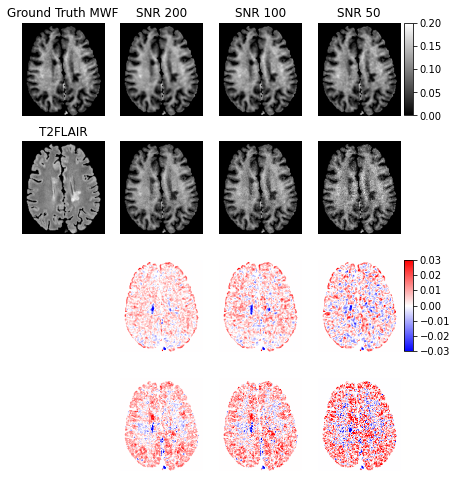

In [254]:
fig, axs = plt.subplots(4,4)
SLICE = 20
arr = [[label, image_u_200, image_u_100, image_u_50],
       [FLAIR, image_a_200, image_a_100, image_a_50],
       [None, err_u_200, err_u_100, err_u_50],
       [None, err_a_200, err_a_100, err_a_50]]
clips = [[[0,0.20], [0,0.20], [0,0.20], [0,0.20], [0,0.20]], 
         [[], [0,0.20], [0,0.20], [0,0.20], [0,0.20]], 
         [[], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03]],
         [[], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03]]]
titles = [[ "Ground Truth MWF", "SNR 200", "SNR 100", "SNR 50"],
          ["T2FLAIR", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"]]
pos = [[1.01,1.369,0.02,0.32], None, [1.01,0.55,0.02,0.318]]
fig.subplots_adjust(right=1.0,top=1.7)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        if (j == 0 and (i == 2 or i == 3)):
            axs[i][j].set_visible(False)
            continue
        sliced = (slice(50,-50),slice(40,-40),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 1:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        if (i == 0 or j == 0):
            axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 3 and (i == 2 or i == 0)):
            cb = fig.add_axes(pos[i])
            cb = fig.colorbar(im, cax=cb)
            if (i > 0):
                cb.set_ticks([0.03,0.02,0.01,0,-0.01,-0.02,-0.03])

### Simulations Visualization No-SR

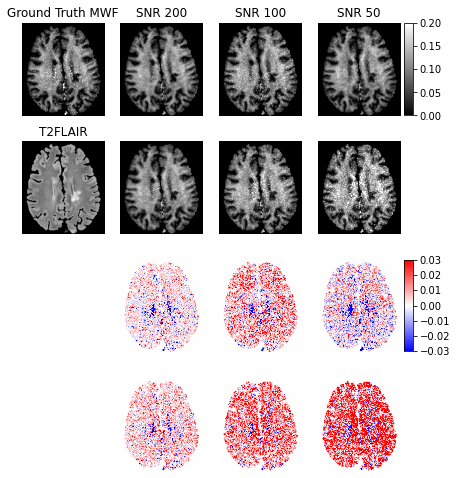

In [256]:


case = '2245'
FLAIR_PATH = {"2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u_50 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_pred_UNET_MWF_256sim_snr50.nii.gz')\
            .get_fdata()/100
image_u_100 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_pred_UNET_MWF_256sim_snr100.nii.gz')\
            .get_fdata()/100
image_u_200 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_pred_UNET_MWF_256sim_snr200.nii.gz')\
            .get_fdata()/100
err_u_50 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_err_UNET_MWF_256sim_snr50.nii.gz')\
            .get_fdata()/100
err_u_100 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_err_UNET_MWF_256sim_snr100.nii.gz')\
            .get_fdata()/100
err_u_200 = nib.load(f'results_v3/unet-2245-simulations-no-sr/MWF/{case}_err_UNET_MWF_256sim_snr200.nii.gz')\
            .get_fdata()/100

image_a_50 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_pred_MLP_256sim_snr50.nii.gz')\
            .get_fdata()/100
image_a_100 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_pred_MLP_256sim_snr100.nii.gz')\
            .get_fdata()/100
image_a_200 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_pred_MLP_256sim_snr200.nii.gz')\
            .get_fdata()/100
err_a_50 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_err_MLP_256sim_snr50.nii.gz')\
            .get_fdata()/100
err_a_100 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_err_MLP_256sim_snr100.nii.gz')\
            .get_fdata()/100
err_a_200 = nib.load(f'results_v3/mlp-2245-simulations-no-sr/MWF/{case}_err_MLP_256sim_snr200.nii.gz')\
            .get_fdata()/100

label = nib.load(f"results_v3/mlp-2245-simulations-no-sr/MWF/2245_label_MLP_256sim_snr100.nii.gz")\
            .get_fdata()/100
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/cropped_mask.nii.gz").get_fdata()
crop = nib.load("2245_crop.nii.gz").get_fdata()
brain_mask[crop == 1] = 0

fig, axs = plt.subplots(4,4)
SLICE = 20
arr = [[label, image_u_200, image_u_100, image_u_50],
       [FLAIR, image_a_200, image_a_100, image_a_50],
       [None, err_u_200, err_u_100, err_u_50],
       [None, err_a_200, err_a_100, err_a_50]]
clips = [[[0,0.20], [0,0.20], [0,0.20], [0,0.20], [0,0.20]], 
         [[], [0,0.20], [0,0.20], [0,0.20], [0,0.20]], 
         [[], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03]],
         [[], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03], [-0.03,0.03]]]
titles = [[ "Ground Truth MWF", "SNR 200", "SNR 100", "SNR 50"],
          ["T2FLAIR", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"]]
pos = [[1.01,1.369,0.02,0.32], None, [1.01,0.55,0.02,0.318]]
fig.subplots_adjust(right=1.0,top=1.7)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        if (j == 0 and (i == 2 or i == 3)):
            axs[i][j].set_visible(False)
            continue
        sliced = (slice(50,-50),slice(40,-40),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 1:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        if (i == 0 or j == 0):
            axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 3 and (i == 2 or i == 0)):
            cb = fig.add_axes(pos[i])
            cb = fig.colorbar(im, cax=cb)
            if (i > 0):
                cb.set_ticks([0.03,0.02,0.01,0,-0.01,-0.02,-0.03])

### Data Consistency

In [17]:
case = '2103'

classes = ['MWF', 'IEWF', 'CSFF', 'MWF_T2', 'IEWF_T2', 'CSFF_T2']
weights_u = []
weights_a = []

for className in classes:
    unetFolder = f"results_v3/unet-sr-mwf-6-echo-6-classes/{className}"
    image_u = nib.load(f'{unetFolder}/{case}_pred_UNET_{className}_real.nii.gz').get_fdata()
    if className in ["MWF", "IEWF", "CSFF"]:
        weights_u.append(image_u / 100)
    else:
        weights_u.append(image_u)
    mlpFolder = f"results_v3/mlp-sr-mwf-6-echo-6-classes/{className}"
    image_a = nib.load(f"{mlpFolder}/{case}_pred_MLP_real.nii.gz").get_fdata()
    if className in ["MWF", "IEWF", "CSFF"]:
        weights_a.append(image_a / 100)
    else:
        weights_a.append(image_a)

fastT2 = nib.load(f"../{case}/FASTT2_FULL.nii.gz").get_fdata()
fastT2 = fastT2.transpose((3,0,1,2))
fastT2 = fastT2 / (fastT2[0]+1e-16)
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()
fastT2 *= brain_mask

In [18]:
simBrain_u = np.zeros(fastT2.shape)
simBrain_a = np.zeros(fastT2.shape)

In [19]:
echoTimes = [0, 7.5, 17.5, 67.5, 147.5, 307.5]
for i in range(len(echoTimes)):
    simBrain_u[i] = weights_u[0] * np.exp(-echoTimes[i] / (weights_u[3] + 1e-16)) + \
                    weights_u[1] * np.exp(-echoTimes[i] / (weights_u[4] + 1e-16)) + \
                    weights_u[2] * np.exp(-echoTimes[i] / (weights_u[5] + 1e-16))
    simBrain_a[i] = weights_a[0] * np.exp(-echoTimes[i] / (weights_a[3] + 1e-16)) + \
                    weights_a[1] * np.exp(-echoTimes[i] / (weights_a[4] + 1e-16)) + \
                    weights_a[2] * np.exp(-echoTimes[i] / (weights_a[5] + 1e-16))
    np.nan_to_num(simBrain_u[i], copy=False)
    np.nan_to_num(simBrain_a[i], copy=False)
simBrain_u[i] *= brain_mask
simBrain_a[i] *= brain_mask

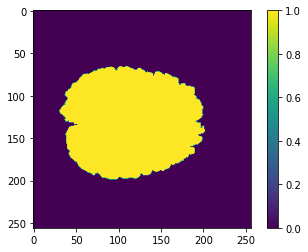

In [24]:
plt.imshow(brain_mask[:,:,20])
plt.colorbar()

In [51]:
def twoNorm(data):
    return np.sum(data**2, axis=0)**0.5

In [59]:
im_u = twoNorm(simBrain_u - fastT2).swapaxes(0,1)
im_a = twoNorm(simBrain_a - fastT2).swapaxes(0,1)

In [60]:
im_u[brain_mask == 1].mean(), im_u[brain_mask == 1].std()

(0.013906584473811698, 0.018364410065803062)

In [61]:
im_a[brain_mask == 1].mean(), im_a[brain_mask == 1].std()

(0.011185975645218187, 0.01402691061983397)

In [55]:
ranksums(im_u[brain_mask == 1], im_a[brain_mask == 1])

RanksumsResult(statistic=51.498438517468834, pvalue=0.0)

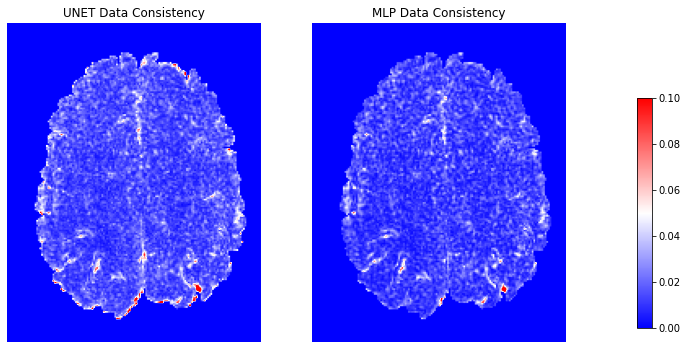

In [57]:
SLICE = 21
sliced = (slice(20,-40),slice(50,-50),SLICE)
im_u = twoNorm(simBrain_u - fastT2).swapaxes(0,1)[sliced]
sliced = (slice(20,-40),slice(50,-50),SLICE)
im_a = twoNorm(simBrain_a - fastT2).swapaxes(0,1)[sliced]
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].set_title("UNET Data Consistency")
axs[0].imshow(np.flipud(im_u), cmap='bwr', vmin=0, vmax=0.1)
axs[1].set_title("MLP Data Consistency")
im = axs[1].imshow(np.flipud(im_a), cmap='bwr', vmin=0, vmax=0.1)
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis('off')

cb = fig.add_axes([1.0,0.3,0.02,0.32])
cb = fig.colorbar(im, cax=cb)

In [15]:
im_a.sum()/brain_mask[sliced].sum()

0.01523952864140606

In [14]:
im_u.sum()/brain_mask[sliced].sum()

0.018707372371698193

In [205]:
(simBrain_u - fastT2).shape

(6, 256, 256, 32)

In [206]:
save_nii(sum(simBrain_a - fastT2), 
         "results_v3/mlp-sr-mwf-6-echo-6-classes/2183_MLP_data_consistency.nii.gz", 
         f"../{case}/FASTT2_FULL.nii.gz")

save_nii(sum(simBrain_u - fastT2), 
         "results_v3/unet-sr-mwf-6-echo-6-classes/2183_UNET_data_consistency.nii.gz", 
         f"../{case}/FASTT2_FULL.nii.gz")

### Testing ROI

In [408]:
np.unique(load_nii("../184051/segmentation.nii.gz"))

array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
         15,   16,   17,   18,   24,   26,   28,   31,   41,   43,   44,
         46,   47,   49,   50,   51,   52,   53,   54,   58,   60,   62,
         63,   77,   85,  251,  252,  253,  254,  255, 1000, 1001, 1002,
       1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 2000,
       2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034,
       2035, 3201, 3203, 3204, 3205, 3206, 3207, 4201, 4203, 4204, 4205,
       4206, 4207, 5001, 5002], dtype=int32)

In [454]:
rois = {
    "whitematter" : [3201, 3203, 3204, 3205, 3206, 3207, 5001, 5002],
}

keys = rois.keys()

def getROIMeanDiff():
    numbers = ['125545', '093924', '151026', '111721', '093923', 
               '151025', '113308', '113307', '171732', '101851', 
               '125546', '163835', '163834', '154655', '101850',
               '175630', '175631', '184052', '111720', '184051']
    values = []
    for number in numbers:
        A_PATH = f"../{number}"
        image_u = nib.load(f"results_v3/unet-healthy/MWF/{number}_pred_UNET_MWF_repro.nii.gz").get_fdata()
        image_n = nib.load(f"{A_PATH}/MWF.nii.gz").get_fdata()
        image_m = nib.load(f"results_v3/mlp-healthy/MWF/{number}_pred_MLP_repro.nii.gz").get_fdata()
        seg_img = nib.load(f"{A_PATH}/segmentation.nii.gz").get_fdata()
        means = {}
        for key in keys:
            means[key] = {}
            mwfs_u = []
            mwfs_n = []
            mwfs_m = []
            for seg_label in rois[key]:
                mwfs_u += image_u[seg_img == seg_label].reshape(-1).tolist()
                mwfs_n += image_n[seg_img == seg_label].reshape(-1).tolist()
                mwfs_m += image_m[seg_img == seg_label].reshape(-1).tolist()
            mwfs_u = np.array(mwfs_u)
            mwfs_n = np.array(mwfs_n)
            mwfs_m = np.array(mwfs_m)
#             diff_u = abs(mwfs_u - mwfs_n).mean()
#             diff_m = abs(mwfs_m - mwfs_n).mean()
            diff_u = abs(mwfs_u.mean() - mwfs_n.mean())
            diff_m = abs(mwfs_m.mean() - mwfs_n.mean())
            means[key]["unet"] = diff_u
            means[key]["mlp"] = diff_m
            means[key]["id"] = number + "-" + str(rois[key][0]) + "-" + key
        values.append(means)
    return values

In [455]:
values = getROIMeanDiff()

In [456]:
wm_unet = np.array([val['whitematter']['unet']/100 for val in values])
print(wm_unet.mean(), wm_unet.std())

0.0012891706378871976 0.0004287897426959286


In [457]:
wm_mlp = np.array([val['whitematter']['mlp']/100 for val in values])
print(wm_mlp.mean(), wm_mlp.std())

0.0007635524084843581 0.0007170052572172241


### Subject Motion

In [471]:
mask = load_nii("../1876/tightmask.nii.gz")
lesion = load_nii("../1876/lesion.nii.gz")
u_err = load_nii("results_v3/unet-sr-mwf-6-echo-6-classes/MWF/1876_err_UNET_MWF_real.nii.gz")
m_err = load_nii("results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/1876_err_MLP_real.nii.gz")

In [475]:
print(abs(u_err)[mask == 1].mean(), abs(u_err)[mask == 1].std())
print(abs(m_err)[mask == 1].mean(), abs(m_err)[mask == 1].std())

0.47336653 0.6928491
1.1222497 1.1893721


In [474]:
print(abs(u_err)[lesion > 0].mean(), abs(u_err)[lesion > 0].std())
print(abs(m_err)[lesion > 0].mean(), abs(m_err)[lesion > 0].std())

0.33406425 0.33872372
0.80637354 0.6323173


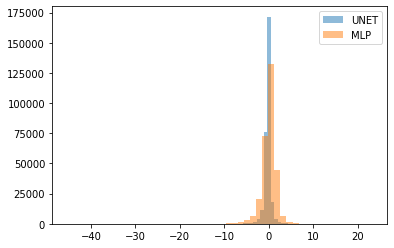

In [468]:
plt.hist(u_err[mask == 1], bins=50, label="UNET", alpha=0.5)
plt.hist(m_err[mask == 1], bins=50, label="MLP", alpha=0.5)
plt.legend()

In [148]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1876": "1876_20190606_083112_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_pred_UNET_MWF_real.nii.gz').get_fdata()
err_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()

image_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()
err_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_err_MLP_real.nii.gz").get_fdata()

label = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes/MWF/{case}_label_MLP_real.nii.gz").get_fdata()
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()



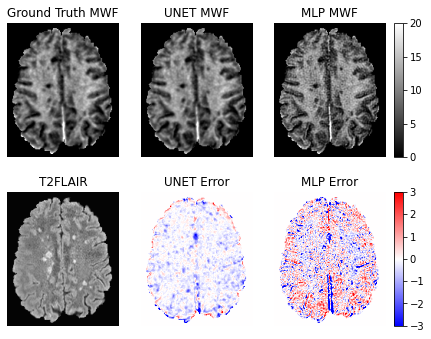

In [149]:
fig, axs = plt.subplots(2,3)
SLICE = 21
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,20], [0,20], [0,20]], [[], [-3,3], [-3,3]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

In [241]:
fov_lesion = np.load("dataset-1-mwf-pred-w-sr-6-echo-6-classes-lesion-fov-bn.npy", allow_pickle=True)
fov_whole = np.load("dataset-1-mwf-pred-w-sr-6-echo-6-classes-whole-brain-fov-bn.npy", allow_pickle=True)

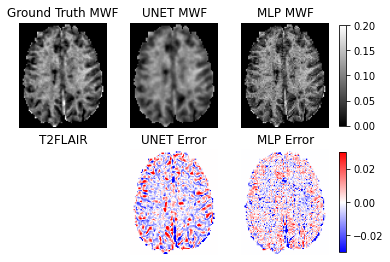

In [403]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1876": "1876_20190606_083112_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes-fov/MWF/{case}_pred_UNET_MWF_real.nii.gz')\
            .get_fdata()/100
err_u = nib.load(f'results_v3/unet-sr-mwf-6-echo-6-classes-fov/MWF/{case}_err_UNET_MWF_real.nii.gz').get_fdata()/100

image_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes-fov/MWF/{case}_pred_MLP_real.nii.gz").get_fdata()/100
err_a = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes-fov/MWF/{case}_err_MLP_real.nii.gz").get_fdata()/100

label = nib.load(f"results_v3/mlp-sr-mwf-6-echo-6-classes-fov/MWF/{case}_label_MLP_real.nii.gz").get_fdata()/100
# FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
# brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

fig, axs = plt.subplots(2,3)
SLICE = 10
arr = [[label, image_u, image_a], [None, err_u, err_a]]
clips = [[[0,0.20], [0,0.20], [0,0.20]], [[], [-0.03,0.03], [-0.03,0.03]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(30,-25),slice(15,-25),SLICE)
        if (len(clips[i][j]) == 2):
            image = arr[i][j][sliced]
            im = ""
            display = image
            display = np.rot90(display)
            if i > 0:
                im = axs[i][j].imshow(display, cmap="bwr", vmin=clips[i][j][0], vmax=clips[i][j][1])
            else:
                im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
#         else:
            
#             im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

### All 6 Parameters

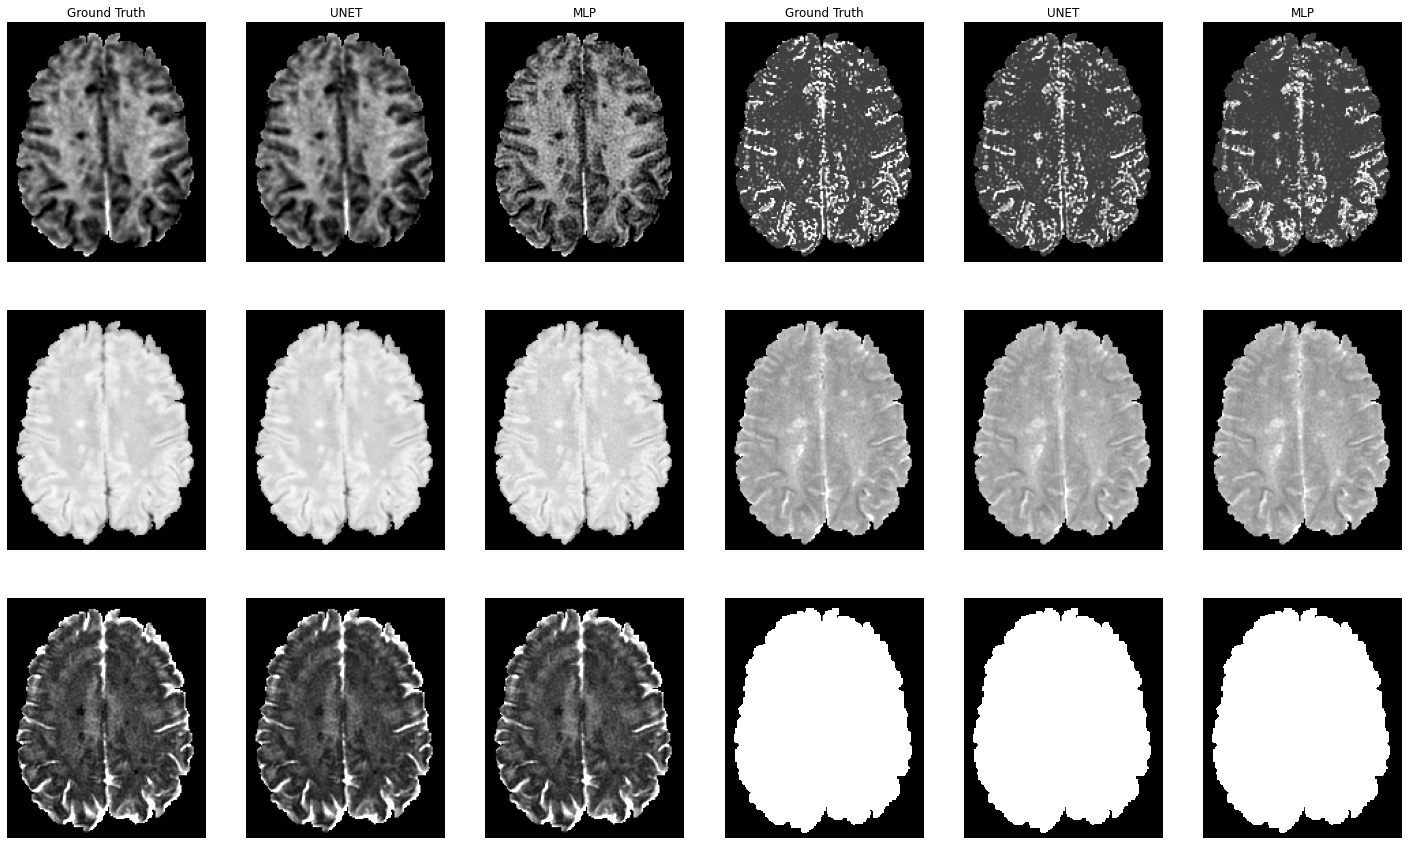

In [229]:
case = '2103'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1876": "1876_20190606_083112_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

fig, axs = plt.subplots(3,6, figsize=(25,15))
SLICE = 21  
titles = ["Ground Truth", "UNET", "MLP", "Ground Truth", "UNET", "MLP"]
features = ["MWF", "IEWF", "CSFF", "MWF_T2", "IEWF_T2", "CSFF_T2"]
clips = [[0,20], [0,100], [0,20], [0,20], [20,200], [200,2000]]
for q in range(len(features)):
    i = int(q % 3)
    for j in range(3):
        if (q >= 3):
            j = 3 + j
        sliced = (slice(60,-50),slice(30,-50),SLICE)
        feat = features[q]
        if i == 0:
            axs[i][j].set_title(titles[j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        image = None
        if j == 0 or j == 3:
            image = load_nii(f"results_v3/mlp-sr-mwf-6-echo-6-classes/{feat}/{case}_label_MLP_real.nii.gz")
        elif j == 1 or j == 4:
            image = load_nii(f'results_v3/unet-sr-mwf-6-echo-6-classes/{feat}/{case}_pred_UNET_{feat}_real.nii.gz')
        elif j == 2 or j == 5:
            image = load_nii(f"results_v3/mlp-sr-mwf-6-echo-6-classes/{feat}/{case}_pred_MLP_real.nii.gz")
        brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()
        image *= brain_mask
        display = image[sliced]
        display = np.rot90(display)
        axs[i][j].imshow(display, cmap="gray", vmin=clips[i][0], vmax=clips[i][1])